In [1]:
%load_ext autoreload
%autoreload 2

## **[edge attr]** *euclidean and normalized direction* 
## **[edge net]** *2 layers*
## **[block dim]** *8,8,8,8*
## **[num blocks]** *9*
## **[init pos]** *scaled random*
## **[loss]** *StressLoss:0.4, RescaledL1AngularLoss:0.6*
## **[loss controller]** *SoftAdapt($\tau$=0.95, $\beta$=1, $p$=0)*
## **[dataset]** *10X Randomly Augmented*

In [2]:
from lib.imports import *
from lib.functions import *
from lib.utils import *
from lib.modules import *
from ipynb.fs.defs.losses import *

In [3]:
torch.__version__

'1.6.0'

In [4]:
torch.cuda.device_count()

0

# Settings

In [5]:
cuda_idx = 0
config = Config('gnn_stress-Copy148.json')
loss_fns = {
    StressLoss(): 0.4,
    RescaledL1AngularLoss(): 0.6
}
model_params = {
    "num_blocks": 9
}
ctrler_params = {
    "tau": 0.95,
    "beta": 1,
    "exploit_rate": 0,
    "warmup": 2
}

In [6]:
config[...]

{'name': 'aug-rand_sa[p:.0]_l[stress:.4,l1:.0.6]',
 'batchsize': 128,
 'epoch': {'start': 0, 'end': None},
 'lr': {'initial': 0.01,
  'decay_rate': 0.99,
  'decay_step': 1,
  'override': {'start_epoch': None,
   'target_lr': None,
   'decay_rate': None,
   'decay_step': None}},
 'log_period': 1,
 'test': {'name': 'test', 'epoch': 77}}

In [7]:
ckpt_folder = lambda: f"./checkpoints/{config.name}"
tb_folder = lambda: f"./tensorboards/{config.name}"
vis_folder = lambda: f'./visualizations/{config.name}_{config.test.name}'
log_file = lambda: f"./logs/{config.name}.log"
metrics_file = lambda suffix: f"./metrics/{config.name}_{suffix}.pickle"

In [8]:
print(f"cd {os.getcwd()}")
print(f"tail -f {log_file()}")

cd /home/jupyter/graph-drawing-stress
tail -f ./logs/aug-rand_sa[p:.0]_l[stress:.4,l1:.0.6].log


In [9]:
if cuda_idx is not None and torch.cuda.is_available():
    device = f'cuda:{cuda_idx}'
    nvidia_smi.nvmlInit()
    cuda = nvidia_smi.nvmlDeviceGetHandleByIndex(cuda_idx)
else:
    device = 'cpu'
    cuda =  None
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [10]:
val_G_list, val_data_list = load_processed_data(G_list_file='../../G_list_1.pickle', 
                                        data_list_file='../../data_list_1.pickle',
                                        index_file='data_index_1.txt')
G_list = torch.load('../../G_list_augmented_random.pickle')
data_list = torch.load('../../data_list_augmented_random.pickle')
train_loader = DataLoader(data_list[:], batch_size=config.batchsize, shuffle=True)
val_loader = DataLoader(val_data_list[11000:], batch_size=config.batchsize, shuffle=False)

In [10]:
G_list, data_list = load_processed_data(G_list_file='G_list_1.pickle', 
                                        data_list_file='data_list_1.pickle',
                                        index_file='data_index_1.txt')
train_loader = DataLoader(data_list[:10000], batch_size=config.batchsize, shuffle=True)
val_loader = DataLoader(data_list[11000:], batch_size=config.batchsize, shuffle=False)

In [11]:
def lr_lambda(epoch):
    current_epoch = config.epoch.start + epoch
    if config.lr.override.start_epoch is not None and current_epoch >= config.lr.override.start_epoch:
        num_step = (current_epoch - config.lr.override.start_epoch) // config.lr.override.decay_step
        return config.lr.override.target_lr * config.lr.override.decay_rate ** num_step
    num_step = current_epoch // config.lr.decay_step
    return config.lr.initial * config.lr.decay_rate ** num_step

In [12]:
def train_callback(*, output, loss, components):
    postfix = {'loss': loss.item()}
    if cuda is not None:
        util_info = nvidia_smi.nvmlDeviceGetUtilizationRates(cuda)
        mem_info = nvidia_smi.nvmlDeviceGetMemoryInfo(cuda)
        postfix['gpu%'] = util_info.gpu
        postfix['mem%'] = mem_info.used / mem_info.total * 100
    progress.update()
    progress.set_postfix(postfix)

In [13]:
def test_callback(*, idx, pred, metrics):
    graph_vis(G_list[idx], pred, f"{vis_folder()}/{idx}_{metrics['scaled_stress']:.2f}_{metrics['resolution_score']:.2f}.png")

# Training

In [ ]:
if not os.path.isdir(ckpt_folder()):
    os.mkdir(ckpt_folder())
    
model = GNNGraphDrawing(**model_params).to(device)
if config.epoch.start > 0:
    state_dict = torch.load(f"{ckpt_folder()}/epoch_{config.epoch.start}.pt", map_location=torch.device(device))
    model.load_state_dict(state_dict)
    
criterion = CompositeLoss(list(loss_fns.keys()))
controller = SoftAdaptController(criterion, gamma=list(loss_fns.values()), **ctrler_params)
optimizer = torch.optim.AdamW(model.parameters(), lr=1)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=lr_lambda)
tensorboard = SummaryWriter(log_dir=tb_folder())
progress = tqdm(total=len(train_loader), smoothing=0)

print("=" * 100, file=open(log_file(), "a"))
epoch = config.epoch.start + 1
while True:
    progress.reset()
    progress.set_description(desc=f"[epoch {epoch}/{config.epoch.end}]")
    train_loss, train_loss_comp = train(model=model, 
                                        criterion=criterion, 
                                        optimizer=optimizer,
                                        data_loader=train_loader, 
                                        callback=train_callback)
    controller.step(train_loss_comp)
    scheduler.step()
    if epoch % config.log_period == 0:
        torch.save(model.state_dict(), f"{ckpt_folder()}/epoch_{epoch}.pt")
        val_loss, val_loss_comp = validate(model=model, 
                                           criterion=criterion,
                                           data_loader=train_loader)
        tensorboard.add_scalars('loss', {'train': train_loss, 
                                         'validation': val_loss}, epoch)
        for i, fn in enumerate(loss_fns):
            tensorboard.add_scalars(type(fn).__name__, {'train': train_loss_comp[i].item(), 
                                                  'validation': val_loss_comp[i].item()}, epoch)
        info = {
            'train':   f'train: {train_loss:.2f} {train_loss_comp}',
            'val':     f'val: {val_loss:.2f} {val_loss_comp}',
            'weights': f'weights: {controller.get_last_weights()}',
            'policy':  f'policy: {controller.get_last_policy()}',
            'lr':      f'lr: {scheduler.get_last_lr()[0]:.2e}',
        }
        print(f"[{epoch:03}] {info['train']}, {info['val']}, {info['weights']}, {info['policy']}, {info['lr']}",
              file=open(log_file(), "a"))
    if epoch == config.epoch.end:
        break
    epoch += 1

# Performance Testing

In [14]:
state_dict = torch.load(f'{ckpt_folder()}/epoch_{config.test.epoch}.pt', map_location=torch.device(device))
model = GNNGraphDrawing(**model_params).to(device)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [15]:
if os.path.isdir(vis_folder()):
    shutil.rmtree(vis_folder())
os.mkdir(vis_folder())

In [16]:
evaluation_criteria = list(loss_fns.keys()) + [SemiNormalizedStressLoss(), EdgeLengthStdLoss()]

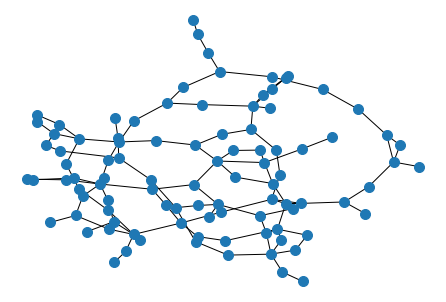

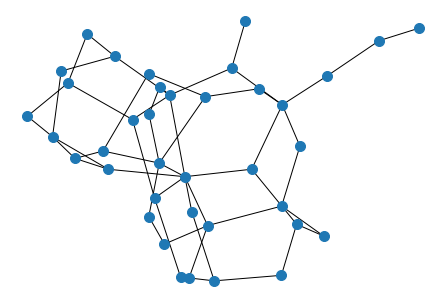

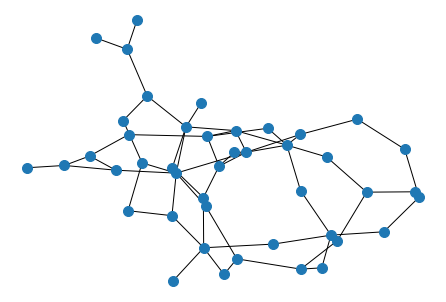

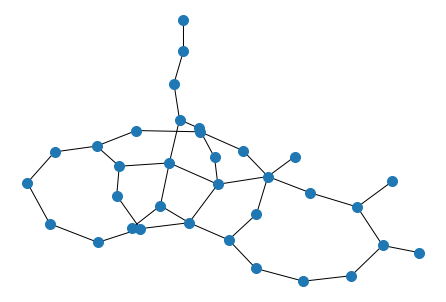

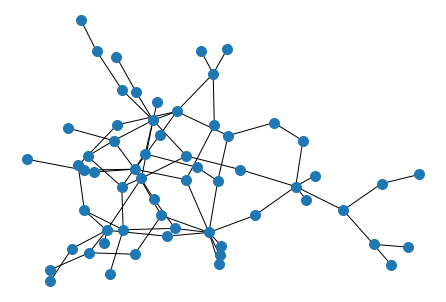

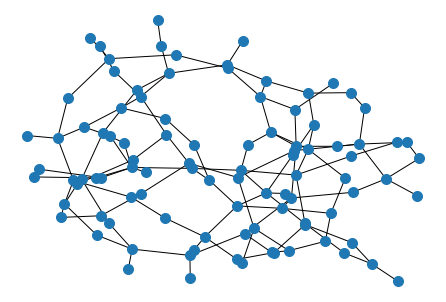

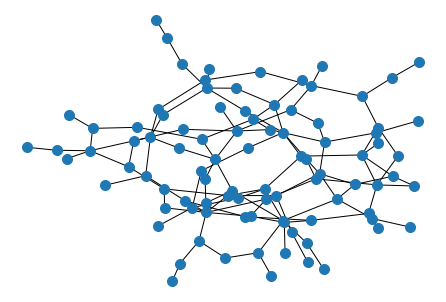

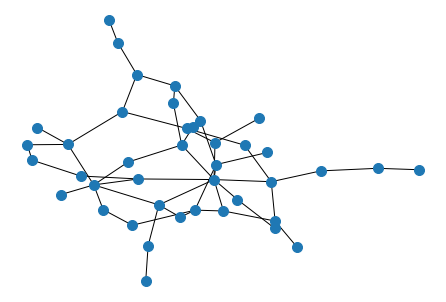

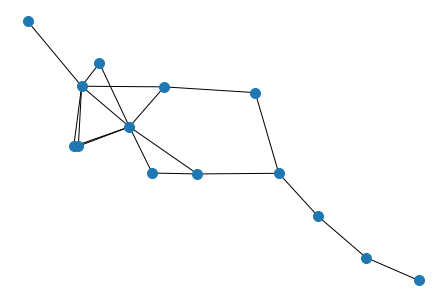

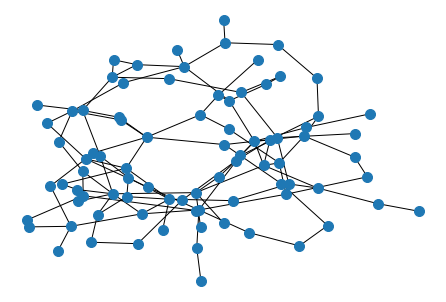

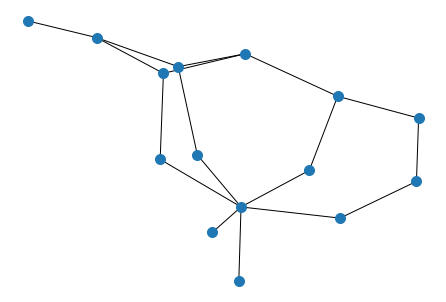

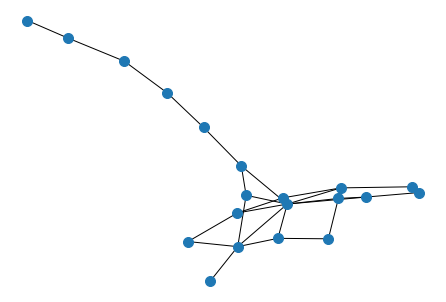

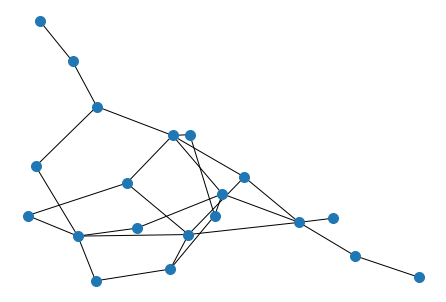

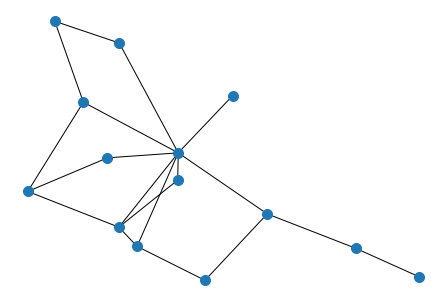

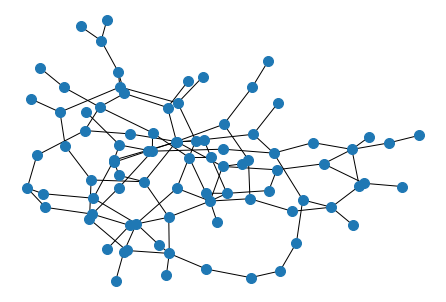

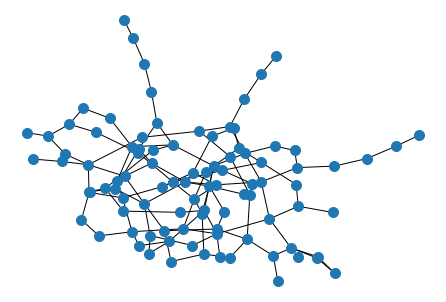

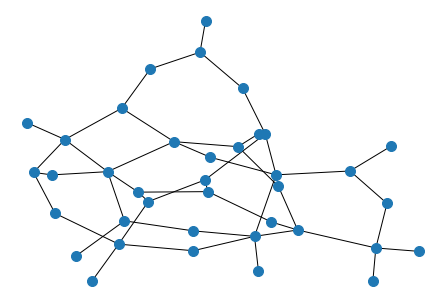

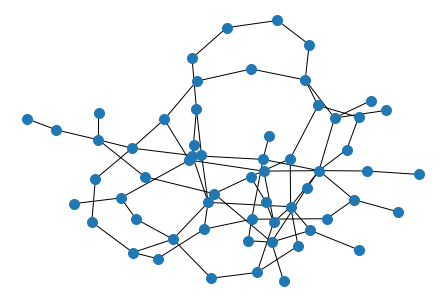

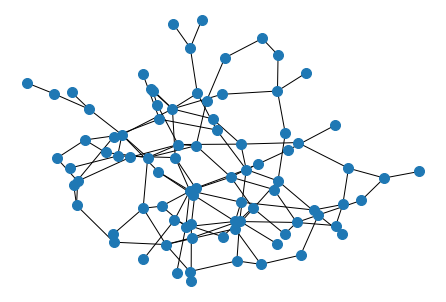

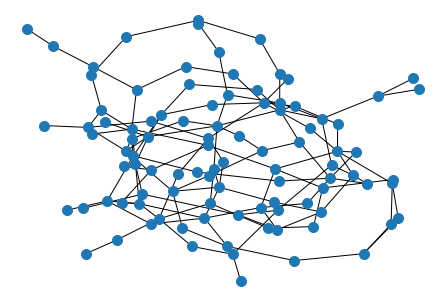

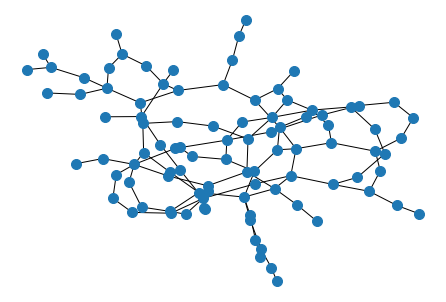

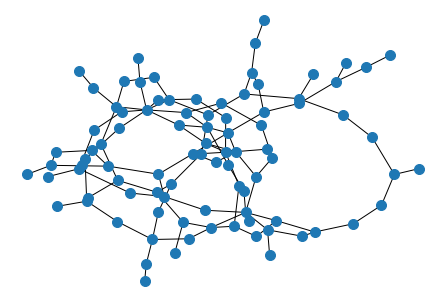

Error in callback <function flush_figures at 0x7f44929a08c0> (for post_execute):


KeyboardInterrupt: 

In [17]:
test_metrics = test(model=model, 
                    criteria_list=evaluation_criteria, 
                    dataset=data_list, 
                    idx_range=range(10000, 11000), 
                    callback=test_callback)
pickle.dump(test_metrics, open(metrics_file("test"), "wb"))

In [18]:
metrics = test_metrics
print('stress:', metrics['stress'].mean())
print('angle_reso:', metrics['losses'].mean(dim=0)[1])
print('norm_stress:', metrics['losses'].mean(dim=0)[2])
print('edge_len_std:', metrics['losses'].mean(dim=0)[3])
print('reso_score:', metrics['resolution_score'].mean())
print('min_angle:', metrics['min_angle'].mean())
print('stress_ratio:', metrics['scaled_stress_ratio'].mean())

stress: tensor(133.2173)
angle_reso: tensor(4715.3872)
norm_stress: tensor(266.4347)
edge_len_std: tensor(0.3138)
reso_score: tensor(0.6332)
min_angle: tensor(7.0575)
stress_ratio: tensor(0.2113)


In [ ]:
train_metrics = test(model=model, 
                     criteria_list=evaluation_criteria, 
                     dataset=data_list, 
                     idx_range=range(10000),
                     callback=None)
pickle.dump(test_metrics, open(metrics_file("train"), "wb"))

In [ ]:
metrics = train_metrics
print('stress:', metrics['stress'].mean())
print('angle_reso:', metrics['losses'].mean(dim=0)[1])
print('norm_stress:', metrics['losses'].mean(dim=0)[2])
print('edge_len_std:', metrics['losses'].mean(dim=0)[3])
print('reso_score:', metrics['resolution_score'].mean())
print('min_angle:', metrics['min_angle'].mean())
print('stress_ratio:', metrics['scaled_stress_ratio'].mean())

In [ ]:
model = Model().to(device)
state_dict = torch.load(f"../ckpt_{config.name}/epoch_{config.test.epoch}.pt",map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
test_idx = 10226
G = G_list[test_idx]
data = data_list[test_idx]
criterion = CompositeLoss([StressLoss(),AngularResolutionMAELossRescale()])
node_pos, loss,component = evaluate(model, data, criterion, device,output_components=True)
graph_vis(G, node_pos,node_size=600, with_labels=True, font_color="white", font_weight="bold", font_size=14) 


In [ ]:
losses = []
loss_ratios = []
for test_idx in tqdm(range(10000, 11000)):
    G_vis = G_list[test_idx]
    node_pos, loss = evaluate(model, data_list[test_idx], criterion, device)
    gt_loss = ground_truth.loc[test_idx][0]
    loss_ratio = (loss - gt_loss) / gt_loss
    losses += [loss]
    loss_ratios += [loss_ratio]

In [ ]:
np.mean(losses), np.std(losses)

In [ ]:
np.mean(loss_ratios), np.std(loss_ratios)

In [ ]:
truth_loss = 0
pred_loss = 0
for idx in tqdm(range(10000, 11000)):
    pred, loss = evaluate(model, data_list[idx], criterion, device)
    pos_map = nx.nx_agraph.graphviz_layout(G_list[idx], prog='neato')

    pred_mean, pred_std = pred.mean(axis=0), pred.std()
    truth = np.array(list(pos_map.values()))
    truth_mean, truth_std = truth.mean(axis=0), truth.std()
    norm_truth = (truth - truth_mean) / truth_std
    scaled_truth = norm_truth * pred_std + pred_mean

    truth_loss += criterion(torch.tensor(scaled_truth), data_list[idx])
    pred_loss += criterion(torch.tensor(pred), data_list[idx])
    
truth_loss / 1000, pred_loss / 1000

In [ ]:
type(data_list[9999].x)

In [ ]:
iterations = 5
losses = []
folder_name = f'{config.name}_{config.test.name}_iterative'
for test_idx in tqdm(range(10000, len(G_list))):
    G_vis = G_list[test_idx]
    node_pos = nx.nx_agraph.graphviz_layout(G_vis, prog='neato')
    plt.figure()
    nx.draw(G_vis, node_pos)
    plt.savefig(f'{folder_name}/{test_idx}.png')
    for i in range(iterations):
        node_pos, loss = evaluate(model, data_list[test_idx], criterion, device) 
        data_list[test_idx].x = torch.tensor(node_pos,dtype=torch.float)
    losses += [loss]
    graph_vis(G_vis, node_pos, f'{folder_name}/{config.test.out_prefix}_iter_model_{test_idx}_{loss}.png')

In [ ]:
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(loss_ep[:1000])
plt.show()

In [ ]:
class EnergyLossScaled(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, p, data, scale):
        edge_attr = data.edge_attr
        # convert per-node positions to per-edge positions
        start, end, n_nodes = node2edge(p, data)
        
        start *= scale
        end *= scale
        
        start_x = start[:, 0]
        start_y = start[:, 1]
        end_x = end[:, 0]
        end_y = end[:, 1]
        
        l = edge_attr[:, 0]
        k = edge_attr[:, 1]
        
        term1 = (start_x - end_x) ** 2
        term2 = (start_y - end_y) ** 2
        term3 = l ** 2
        term4 = 2 * l * (term1 + term2).sqrt()
        energy = k / 2 * (term1 + term2 + term3 - term4)
        return energy.sum()

In [ ]:
criterion_scaled = EnergyLossScaled()
criterion = EnergyLossVectorized()

In [ ]:
truth_loss = 0
pred_loss = 0
for idx in tqdm(range(10000, 11000)):
    pred, loss = evaluate(model, data_list[idx], criterion, device)
    pos_map = nx.nx_agraph.graphviz_layout(G_list[idx], prog='neato')

    pred_mean, pred_std = pred.mean(axis=0), pred.std()
    truth = np.array(list(pos_map.values()))
    truth_mean, truth_std = truth.mean(axis=0), truth.std()
    norm_truth = (truth - truth_mean) / truth_std
    scaled_truth = norm_truth * pred_std + pred_mean

    truth_loss += criterion(torch.tensor(scaled_truth, device=device), data_list[idx])
    pred_loss += criterion(torch.tensor(pred, device=device), data_list[idx])
    
truth_loss / 1000, pred_loss / 1000

In [ ]:
for idx in [10898, 10904]:#tqdm(range(10000, 11000)):
    data, G = data_list[idx], G_list[idx]
    edge_attr = data.edge_attr
    pred, loss = evaluate(model, data, criterion, device)
    pos_map = nx.nx_agraph.graphviz_layout(G, prog='neato')
    truth = np.array(list(pos_map.values()))

    start, end, n_nodes = node2edge(torch.tensor(truth, device=device), data)
    w = edge_attr[:, 1]
    d = edge_attr[:, 0]

    u2 = ((start - end) ** 2).sum(dim=1)

    s = (w * d * u2.sqrt()).sum() / (w * u2).sum()

    loss_gt = criterion_scaled(torch.tensor(truth, device=device), data, s)

    print(loss, loss_gt)

In [ ]:
def evaluate(model, data, criterion, device, idx):
    model.eval()
    with torch.no_grad():
        data = data.to(device)
        pred = model(data).detach()
        loss = criterion(pred,data).cpu().numpy()
        loss = round(float(loss),2)
    return pred.cpu().numpy(), loss

def graph_vis(G, node_pos):
    i = 0
    for n, p in node_pos:
        node = 'n' +str(i)
        G.nodes[node]['pos'] = (n,p)
        i += 1
    pos = nx.get_node_attributes(G,'pos')
    plt.figure()
    nx.draw(G, pos)
    
for test_idx in tqdm(list(range(10000, len(data_list)))):
    G_vis = G_list[test_idx]
    node_pos,loss = evaluate(model, data_list[test_idx],criterion,device, test_idx)
    if loss > 10000:
        print(test_idx, loss, data_list[test_idx].num_nodes)
        graph_vis(G_vis, node_pos) 
        node_pos = nx.nx_agraph.graphviz_layout(G_vis, prog='neato')
        plt.figure()
        nx.draw(G_vis, node_pos)

# Eval with Projection

In [ ]:
idx = 10117
pred, loss, sloss, aloss = evaluate(model, data_list[idx], criterion, device, output_components=True, reduction=umap_project)
graph_vis(G_list[idx], pred, f'composite_umap_{idx}_loss_{sloss}_{aloss}.png')
print(sloss, aloss)

# Iterative Evaluation

In [ ]:
iterations = 100
losseses = []
folder_name = f'{config.name}_{config.test.name}_iterative'
if not os.path.isdir(folder_name):
    os.mkdir(folder_name)
for test_idx in tqdm(range(10000, 10500)):
    G_vis = G_list[test_idx]
#     node_pos = nx.nx_agraph.graphviz_layout(G_vis, prog='neato')
#     plt.figure()
#     nx.draw(G_vis, node_pos)
#     plt.savefig(f'{folder_name}/{test_idx}.png')
    losses = []
    for i in range(iterations):
        node_pos, loss, stress, angle = evaluate(model, data_list[test_idx], criterion, device, output_components=True, with_initial_pos=True) 
        data_list[test_idx].x = torch.tensor(node_pos,dtype=torch.float)
        losses += [loss]
    losseses += [losses]
    graph_vis(G_vis, node_pos, f'{folder_name}/{config.test.out_prefix}_iter_model_{test_idx}_{stress}_{angle}.png')

In [ ]:
_, bins, _ = plt.hist(np.array(losseses).std(axis=1), bins=10)
plt.clf()
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
count, bins, _ = plt.hist(np.array(losseses).std(axis=1), bins=logbins, rwidth=0.5, log=False)
plt.xscale('log')
plt.title('Distribution of std(loss)')

In [ ]:
pd.options.display.float_format = '{:,.2e}'.format
pd.DataFrame([bins[:-1], bins[1:], count], index=['min', 'max', 'count']).T.astype({'count': 'int64'})

# Visualization

In [ ]:
model = torch.load(f'../ckpt_{config.name}/epoch_{config.test.epoch}.pt', map_location=torch.device(device))

In [ ]:
G, data = G_list[0], data_list[0]

In [ ]:
hidden = model(data, output_hidden=True, numpy=True)[1:10]
projected = list(map(pca_project, hidden))
for i in range(9):
    graph_vis(G, projected[i])

In [ ]:
torch.tensor([1,2,3]).square()

In [ ]:
config

In [ ]:
result